# Load AroodV3

## Imoprts

In [1]:
import tensorflow as tf
import numpy as np
import os
import re
from random import shuffle
from pyarabic import araby
from tensorflow.keras.layers import GRU, Embedding, Dense, Input, Dropout, Bidirectional
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.utils import shuffle
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

## Load DataSet

### Read label

In [2]:
label_file = os.path.join('./final_baits', 'labels.txt')
with open(label_file, 'r') as f:
    label2name = [line.strip() for line in f.readlines()]

### Preprocessing DataSet

In [3]:
def preprocess_prosody(text: str) -> str:
    text = text.strip()
    # Handle rare edge cases
    if not text:
        return ""
    # Rule handling improvements (combine related regexes, optimize processing)
    text = re.sub(r'[ًٌٍ]', 'ن', text)  # Tanween normalization
    text = re.sub(r'(.)ّ', r'\1\1', text)  # Handle Shadda
    text = re.sub(r'\bال([تثدذرشصضطظلن])', r'ا\1', text)  # Solar Lam simplification
    return text

In [4]:
def extract_data(path, on_shatrs=False):
    global vocab
    text = ""
    X, y = [], []

    # Read the file with UTF-8 encoding
    with open(path, 'r', encoding='utf-8') as file:
        t = file.read()

    t = preprocess_prosody(t)
    t = araby.strip_tatweel(t)
    
    # Remove unwanted characters
    excluded_chars = '!()*-ـ.:=o[]«»;؛,،~?؟\u200f\ufeffـ\xa0'
    cleaned_text = ''.join([char for char in t if char not in excluded_chars])
    
    text += cleaned_text
    baits = cleaned_text.split('\n')
    for line in baits:
        if len(line) <= 1:  # Skip empty or short lines
            continue
        label, bait = line.split(' ', 1)  # Split label and text
        label = int(label)
        bait = bait.strip()
        if on_shatrs:
            # Further split text into parts (shatrs)
            shatrs = bait.split('#')
            for shatr in shatrs:
                X.append(shatr.strip())
                y.append(label)
        else:
            X.append(bait.strip())
            y.append(label)
    
    # Create a sorted vocabulary from the dataset
    vocab = sorted(set(' '.join(X)))

    # Shuffle the data to avoid order bias
    X, y = shuffle(X, y)
    return X, y

### Read Train Data & Test Data

In [5]:
train_file = os.path.join('./final_baits', 'train.txt')
test_file = os.path.join('./final_baits', 'test.txt')

In [6]:
X, y = extract_data(train_file, on_shatrs=False)

In [7]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.15, random_state = 41)

In [8]:
X_test, y_test = extract_data(test_file, on_shatrs=False)

In [9]:
char2idx = {u:i+1 for i, u in enumerate(vocab)}

In [10]:
def to_sequences(X):
    X = [[char2idx.get(char, 0) for char in line] for line in X]
    X = pad_sequences(X, padding='post', value=0, maxlen=100)
    return X

In [11]:
X_train = to_sequences(X_train)
y_train = np.array(y_train)

In [12]:
X_test = to_sequences(X_test)
y_test = np.array(y_test)

## Load AroodV3

In [13]:
# Load best model
model = tf.keras.models.load_model('AroodV3.keras')

## Evaluate Model

### Train Data

1252/1252 [==============================] - 33s 24ms/step
Train Accuracy: 0.9844
Classification Report:
              precision    recall  f1-score   support

       saree       0.96      0.96      0.96      3640
       kamel       0.98      0.98      0.98      3583
   mutakareb       0.99      0.99      0.99      3597
   mutadarak       0.99      0.99      0.99       943
    munsareh       0.99      0.99      0.99      3173
      madeed       0.99      0.97      0.98      1005
     mujtath       0.99      0.99      0.99      1566
       ramal       0.99      0.99      0.99      3667
      baseet       0.98      0.99      0.99      3605
     khafeef       0.99      0.99      0.99      3614
      taweel       0.99      1.00      1.00      3606
       wafer       0.98      0.99      0.98      3606
       hazaj       0.99      0.98      0.99       876
       rajaz       0.98      0.95      0.97      3574

    accuracy                           0.98     40055
   macro avg       0.99      

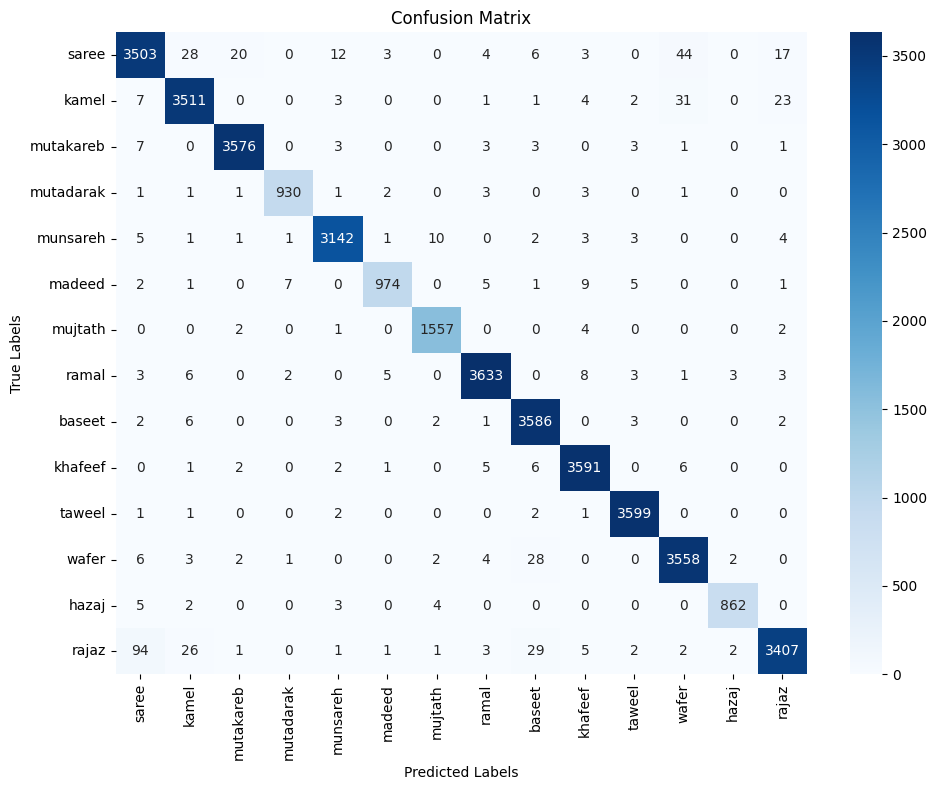

In [14]:
# Predict on test data
y_pred_probs = model.predict(X_train)

# Convert probabilities to class labels
y_pred = np.argmax(y_pred_probs, axis=1)

# Calculate accuracy
accuracy = accuracy_score(y_train, y_pred)
print(f"Train Accuracy: {accuracy:.4f}")

# Display classification report
print("Classification Report:")
report = classification_report(y_train, y_pred, target_names=label2name)
print(report)

# Display confusion matrix
conf_matrix = confusion_matrix(y_train, y_pred)

# Plot Confusion Matrix as Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=label2name, yticklabels=label2name)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()  # Ensure the labels fit within the plot
plt.show()

### Test Data

260/260 [==============================] - 6s 23ms/step
Test Accuracy: 0.9570
Classification Report:
              precision    recall  f1-score   support

       saree       0.89      0.93      0.91       731
       kamel       0.94      0.95      0.94       760
   mutakareb       0.98      0.99      0.98       758
   mutadarak       0.93      0.94      0.94       178
    munsareh       0.97      0.95      0.96       681
      madeed       0.94      0.87      0.90       230
     mujtath       0.95      0.97      0.96       303
       ramal       0.97      0.96      0.97       719
      baseet       0.97      0.99      0.98       752
     khafeef       0.97      0.98      0.97       759
      taweel       0.98      1.00      0.99       752
       wafer       0.97      0.97      0.97       769
       hazaj       0.94      0.95      0.94       168
       rajaz       0.95      0.89      0.92       756

    accuracy                           0.96      8316
   macro avg       0.95      0.95

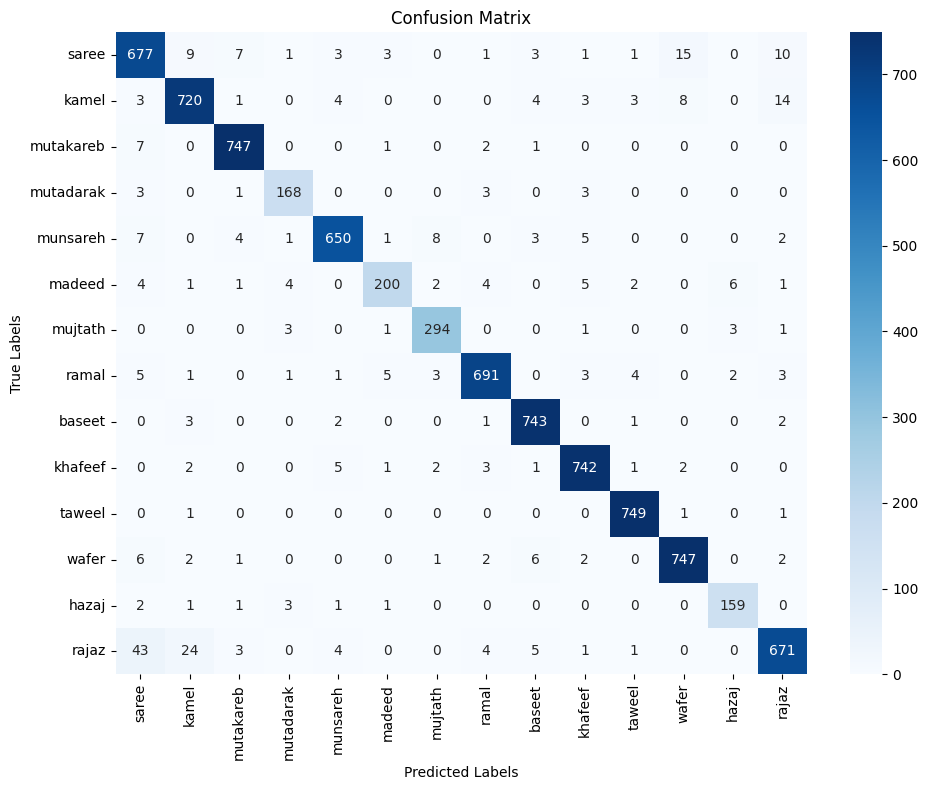

In [15]:
# Predict on test data
y_pred_probs = model.predict(X_test)

# Convert probabilities to class labels
y_pred = np.argmax(y_pred_probs, axis=1)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.4f}")

# Display classification report
print("Classification Report:")
report = classification_report(y_test, y_pred, target_names=label2name)
print(report)

# Display confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot Confusion Matrix as Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=label2name, yticklabels=label2name)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()  # Ensure the labels fit within the plot
plt.show()

## Classify Function

In [16]:
def classify(sentence):
    sentence = preprocess_prosody(sentence)
    sentence = araby.strip_tatweel(sentence)
    sentence = re.sub(r'[\xa0\u200b\u200c]', ' ', sentence)  # Replace non-breaking space and zero-width spaces with regular spaces
    sequence = [char2idx[char] for char in sentence]
    sequence = pad_sequences([sequence], maxlen = X_train.shape[1], padding='post', value=0)

    pred = model.predict(sequence)[0]
    print(label2name[np.argmax(pred, 0).astype('int')], np.max(pred))

## Test

In [17]:
classify("ما تردون على هذا المحب # دائبا يشكو إليكم في الكتب")
classify("ولد الهدى فالكائنات ضياء # وفم الزمان تبسم وسناء")
classify("لك يا منازل في القلوب منازل # أقفرت أنت وهن منك أواهل")
classify("ومن لم يمت بالسيف مات بغيره # تعددت الأسباب والموت واحد")
classify("يا من تقدَّس عن أن # يحيط وصف بذاته")
classify("ولا تنسي معذبتي # بأني في الهوى إنسانْ")
classify ("تَاللَهِ لا يَذهَبُ شَيخي باطِلا # حَتّى أُبيرَ مالِكاً وَكاهِلا")
classify("وَدِّع أُمامَةَ وَالتَوديعُ تَعذيرُ # وَما وَداعُكَ مَن قَفَّت بِهِ العيرُ")
classify("إني لَعَمركَ مَا أخشَى إِذَا ذُكِرَت # مِنِّي الخَلاَئِقُ في مُستَكرِهِ الزَّمَنِ")
classify("فَأَمْكَنَهَا وَوَاصَلَ كلَّ وصْلٍ # فَأَعْيَتْهُ وَصَدَّتْ كلَّ صَدِّ")

1/1 [==============================] - 0s 33ms/step
ramal 0.9999192
1/1 [==============================] - 0s 31ms/step
kamel 0.9834827
1/1 [==============================] - 0s 32ms/step
kamel 0.9697766
1/1 [==============================] - 0s 32ms/step
taweel 0.38481468
1/1 [==============================] - 0s 35ms/step
mujtath 0.9990709
1/1 [==============================] - 0s 34ms/step
hazaj 0.9995437
1/1 [==============================] - 0s 31ms/step
rajaz 0.9997428
1/1 [==============================] - 0s 33ms/step
baseet 0.96620744
1/1 [==============================] - 0s 32ms/step
baseet 0.98087627
1/1 [==============================] - 0s 36ms/step
wafer 0.9974095
